# Data re-uploading for a single-qubit universal classifier - Vol. II

## A new model for Quantum Machine Learning with one or few qubits


### Abstract
Welcome, qiskitters. This is the second part of the tutorial *Data re-uploading for a single-qubit universal classifier*. We have learnt a little bit about Quantum Machine Learning and how to use the IBMQ Quantum Computers for solving problems related to Supervised Machine Learning. We will extend the idea previously explained for classifying data with more than two classes with one qubit. This tutorial is based on the work in [1].


### Introduction
In the first part of the tutorial we classified points from a plane to be inside or outside a circle using one qubit and classical optimizers. A picture of obtained results can be seen in Fig. 1. However, we can take one further step, which is classifying a non-binary data set. We will show now how to do it for a very simple classifying task.

<img src="circle_example.png" width="300"> <img src="circle_example_2.png" width="300"> 
*Fig. 1: Results obtained in the first part of the tutorial for classifying one circle with only one qubit and a classical optimizer. This result was obtained with a noisy simulation.*
<br>


The scheme we will follow in this notebook is explained in the first part of the tutorial. Everything which is not explicitly mentioned here is taken to be equal to the previous case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import itertools
from scipy.optimize import minimize

from functions_aux import *

from qiskit import QuantumCircuit, Aer, execute, IBMQ, transpile
from qiskit.providers.aer import QasmSimulator, noise

IBMQ.load_account()

simulator='qasm_simulator'
quantum_device='ibmqx2'

### A non-binary problem: Classifying four quadrants

Let us take an area equal to the one used in the Vol. I of this tutorial. However, this time we will divide the area in 4 quadrants, i. e., right - left and up - down. As before, we want to know to which quadrant of a given area belongs a given point. The training dataset of this problem is below.

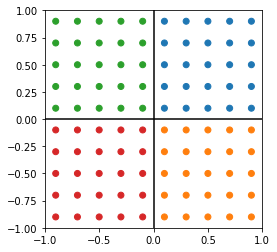

In [2]:
grid = 10
x = np.linspace(-.9,.9,grid)
X = list(itertools.product(x, x))
X_train = np.asfarray(X)
Y_train = squares_labels(X_train)

fig = draw_squares((X_train, Y_train))

This problem is harder than the circle problem because it is non-binary. The difficulty of the problem comes from the fact that now we want to classify points into four different labels. One qubit does not have dimension four in its Hilbert space, it is simply not possible to find four orthogonal states. Nevertheless, there is a smart manner of circumventing this problem.

#### The single-qubit solution: exploiting the infinite space of the Bloch sphere

As Richard Feynman said, *there is plenty of room at the bottom*. It is true that the dimension of the Hilbert space of one qubit is just $2$. However, the number of possible configurations of one qubit is formally infinite. We will take advantage of this fact to classify datasets with more than 2 classes. Instead of using the two poles of the Bloch sphere, we will use a different set of states as the labels of our data. In this case, we want to get four labels, so we need four label states, chosen as follows:

$$
| \psi_0 \rangle = \begin{pmatrix}1 \\ 0  \end{pmatrix} \qquad
| \psi_1 \rangle = \begin{pmatrix}\sqrt{1/3} \\ \sqrt{2 / 3} \end{pmatrix}  \qquad
| \psi_2 \rangle = \begin{pmatrix}\sqrt{1/3} \\ \sqrt{2 / 3}e^{\frac{2\pi i}{3}} \end{pmatrix}  \qquad
| \psi_3 \rangle = \begin{pmatrix}\sqrt{1/3} \\ \sqrt{2 / 3}e^{\frac{-2\pi i}{3}} \end{pmatrix} \qquad
$$

These states are chosen for being the four verteices of a tetrahedron inscribed in the Bloch Sphere. This way, the four states are maximally orthogonal between them, and each dominates over the largest possible area. Notice that, for any state $|\phi\rangle$ this configuration satisfies that
$$
\sum_{i=0}^3 |\langle\phi|\psi_i\rangle|^2 = 2
$$

It is easy to get these states starting with the $|0\rangle$ state. We just have to adjust the parameters of a $U_3$ gate.

We can represent those states in the Bloch sphere using `qiskit`.

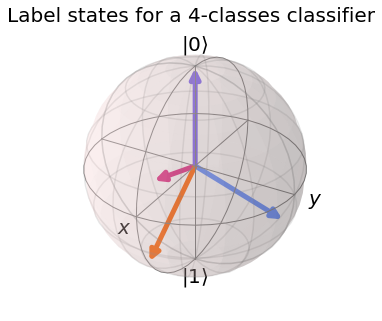

In [3]:
from qiskit.visualization import plot_bloch_vector
psi0=[0,0,1]
psi1=[np.sqrt(2/3), 0,-1/np.sqrt(3)]
psi2=[-np.sqrt(1/6),1/np.sqrt(2),-1/np.sqrt(3)]
psi3=[-np.sqrt(1/6),-1/np.sqrt(2),-1/np.sqrt(3)]
plot_bloch_vector([psi3, psi2, psi1, psi0], title='Label states for a 4-classes classifier', figsize=[4,4])

We define now the circuit, in the fashion from the circuits in the first part of the tutorial.  
<img src="4classes_1qubit.png" width="400"> 
*Fig. 2: Circuit for the classification of four quadrants. The $V_i$ gate represents the gate needed for creating all different $| \psi_i\rangle$ labelling the classes.*
<br>

In [4]:
def measurement_squares_1q(x, y, parameters, device, err_like_dev, noise_objects):
    """
    Create the basic circuit for this problem
    Input:
        x: the x input of the data
        y: the label of the data
        parameters: variables of the classifier
        device: name of the IBMQ device in which we want to run the circuit, it can be a qasm simulator or a real device
        err_like_dev: which device we want to take as noise mode
                It will only work if device is the qasm simulator, otherwise it has no effect
        noise_objects: noise model, coupling map and basis gates for the error model
                
    Output:
        The fidelity between the state given by (x, y) and its corresponding label state
    Notice that the circuit is designed in a way that fits the architecture of 'ibmqx2'
    """
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
        # Error message in case the number of parameters does not fit the problem
        
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5) # It is easier to manage variables this way
    
    C = QuantumCircuit(3,1) # We create the Quantum circuit, we need 3 qubits and one classical register
    
    theta = 2 * np.arccos(1/np.sqrt(3)) #Auxiliary angle for creating label states
    
    if y == 1:
        C.u3(theta, 0, 0, 1)
    
    elif y == 2:
        C.u3(theta, 2 * np.pi / 3, 0, 1)
    
    elif y == 3:
        C.u3(theta, -2 * np.pi / 3, 0, 1) # These gates will appear depending on the class of the point

    
    C.h(2) # This is part of the SWAP test
    
    for l in range(layers): 
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 4], 0)
        # This loop creates all unitary gates for classifying data, there is one gate per layer
        
    C.cswap(2, 0, 1) # This is part of the SWAP test
    C.h(2) # This is part of the SWAP test
    C.measure([2], [0])  # This is part of the SWAP test, will give us the fidelity
    
    try:
        backend = Aer.get_backend(device)# Try to select the QasmSimulator from the Aer provider
        
    except: # If the device given is not the qasm simulator
        provider = IBMQ.get_provider(hub='ibm-q') 
        backend=provider.get_backend(device)  # This selects the real devices, one must be logged into IBMQ for using the function
        C=transpile(C, backend=backend, optimization_level=1) # Transpiling of the circuit, this adjusts the circuit to be convenient for the chosen provider, the optimization level can be adjusted for better results


    sh = 1024 # Number of shots for the execution, this can be easily changed
    if err_like_dev!= None: # In case we want a noise model, other functions are designed to make this work even with no input variables in the function
        noise_model, coupling_map, basis_gates = noise_objects # Unpack the noise objects, this way we do not have to compute them every time
        result = execute(C, backend, shots=sh, noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result() # Execution
    else: # If we consider the device as fault tolerant
        result = execute(C, backend, shots=sh, optimization_level = 1).result() # Execution
    counts = result.get_counts(C) # Get the number of counts for each state
    fidelity = 2 * counts['0'] / sh - 1 # Compute the fidelity 
    return fidelity


def check_squares_1q(X, parameters, device, err_like_dev=None):
    """
    Compute the guessed label of a X dataset, this function needs no labels
    Input:
        X: the x input of the dataset
        parameters: variables of the classifier, which at this point should be optimized for good results
        device: name of the IBMQ device in which we want to run the circuit, it can be a qasm simulator or a real device
        err_like_dev: which device we want to take as noise mode
                It will only work if device is the qasm simulator, otherwise it has no effect
                
    Output:
        The fidelity between the state given by (x, y) and its corresponding label state
    """
    noise_objects=None # This section creates the noise model in case we want it
    if err_like_dev!= None:
        print('Checking with noise model')
        provider = IBMQ.get_provider(hub='ibm-q')
        err_device = provider.get_backend(err_like_dev)
        properties = err_device.properties()
        coupling_map = err_device.configuration().coupling_map
        noise_model = noise.device.basic_device_noise_model(properties)
        basis_gates = noise_model.basis_gates
        noise_objects = noise_model, coupling_map, basis_gates
        
    Fidelities = np.empty((len(X), 4)) # Empty vector for all fidelities
    for i,x in enumerate(X):
        for y in range(4):
             Fidelities[i, y]= measurement_squares_1q(x, y, parameters, device, err_like_dev, noise_objects) # Checks if it is inside the circle 

    return Fidelities
    
    
def cost_function_squares_1q(parameters, Data, device, err_like_dev, noise_objects):
    """
    Compute the cost function for a dataset
    Input:
        Data = (X, Y): the x and y input of the dataset
        parameters: variables of the classifier, which at this point should be optimized for good results
        device: name of the IBMQ device in which we want to run the circuit, it can be a qasm simulator or a real device
        err_like_dev: which device we want to take as noise mode
                It will only work if device is the qasm simulator, otherwise it has no effect
        noise_objects: noise model, coupling map and basis gates for the error model
                
    Output:
        The cost function for a training Dataset
    """
    noise_model, coupling_map, basis_gates = noise_objects
    X = Data[0]
    Y = Data[1]
    chi2 = 0
    for x, y in zip(X, Y):
        chi2 += (1 - measurement_squares_1q(x, y, parameters, device, err_like_dev, noise_objects))**2 # Compute the cost function for every point and sum them all
        
    return chi2 / len(Y)

def get_optimal_parameters(parameters, Data, device, err_like_dev=None):
    """
    Get the optimal parameters of a Dataset
    Input:
        Data = (X, Y): the x and y input of the dataset
        parameters: variables of the classifier, which at this point should be optimized for good results
        device: name of the IBMQ device in which we want to run the circuit, it can be a qasm simulator or a real device
        err_like_dev: which device we want to take as noise mode
                It will only work if device is the qasm simulator, otherwise it has no effect
                
    Output:
        Optimal parameters
    """
    noise_objects=(None, None, None) # This section creates the noise model in case we want it
    if err_like_dev!= None:
        print('Optimization with noise model')
        provider = IBMQ.get_provider(hub='ibm-q')
        err_device = provider.get_backend(err_like_dev)
        properties = err_device.properties()
        coupling_map = err_device.configuration().coupling_map
        noise_model = noise.device.basic_device_noise_model(properties)
        basis_gates = noise_model.basis_gates
        noise_objects = noise_model, coupling_map, basis_gates
        
    result_min = minimize(cost_function_squares_1q, parameters, args=((X_train, Y_train), simulator, err_like_dev, noise_objects), method='Powell')
    
    return result_min

We must now optimize the parameters as in the first part of the tutorial. Everything is done in the same manner until we get the optimal parameters. These are again provided for simplicity.

In [5]:
#layers=1
#parameters = np.zeros(5*layers)
#solution = get_optimal_parameters(parameters,(X_train, Y_train), simulator, None)

In [6]:
# Optimized parameters for different numbers of layers
# Commented we can see the value of the cost function after minimization
# These values were obtained with the qasm simulator with no noise model

sol2= np.array([-0.238873  ,  0.96326096,  2.29141026, -0.39870389, -2.15164795,
       -1.92529151,  1.98063197,  0.50320325,  0.67590627,  1.28547386]) #0.04645973

sol3 = np.array([ 1.76920525, -1.2262498 ,  1.19195069,  1.4974693 ,  4.37513302,
       -0.03020798,  0.74452661,  1.88159056,  1.36368789,  0.64333014,
       -0.04983991,  1.1789682 , -0.48450897, -0.5229465 ,  0.48910178]) #0.02965569

sol4=np.array([ 2.75863799,  0.22982122, -2.84580892,  1.57901683, -5.08838378,
       -0.66882659,  0.48172774,  1.02222475,  0.56508846,  0.76367837,
        0.67683383,  1.42199148,  0.65057268,  0.84085959,  0.72407228,
        0.27771849,  0.61770242, -0.64734714,  1.03078973,  0.23884424]) #0.05747875
                
sol5=np.array([-2.2098064 ,  1.06829506,  0.04794565,  1.39550784,  8.67143781,
       -0.78979345, -0.26027616,  0.974604  ,  1.05659761,  0.63280086,
       -0.84336565,  0.62194456,  0.86780466,  0.76096462,  1.3995512 ,
        0.17556655,  0.66846998,  1.29947557,  0.50552334,  0.56689907,
       -0.31511069,  1.06892719, -0.09362675, -0.75897657,  0.6986746 ]) #0.0334993

optimal_parameters=sol3

Now we have four different label states and we must measure the fidelity of our data state with all of them. Thus, we get a collection of 4 fidelities for every point in the dataset. How do we choose the label of one point from these fidelities? As a first approximation, we will choose the maximum of them and pick the corresponding class.

The classifier guesses the right label a 90 % of times


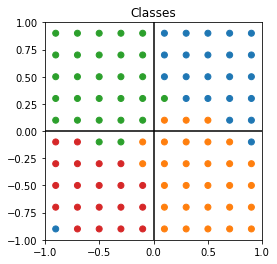

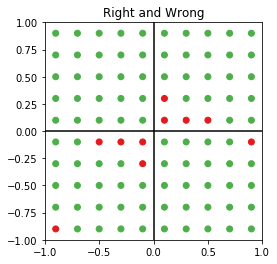

In [7]:
F_train = check_squares_1q(X_train, optimal_parameters, simulator)

fig=draw_squares((X_train, np.argmax(F_train, axis=1)), title = 'Classes')

checks_train = (Y_train==np.argmax(F_train, axis=1)).astype(int)
fig=draw_squares((X_train, checks_train), check=True, title='Right and Wrong')

print('The classifier guesses the right label a {} % of times'.format(100* sum(checks_train) // len(checks_train)))

As in the first part, we have got a pretty good result with the training set. However, we still have to test this classifier against unseen data. 


The classifier guesses the right label a 82 % of times


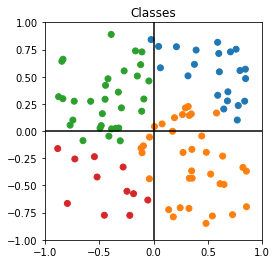

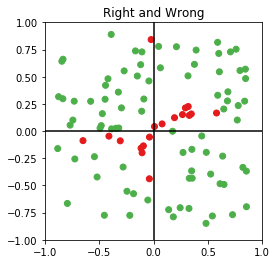

In [8]:
test=100
X_test = 1.8*np.random.rand(test, 2) - .9
Y_test = squares_labels(X_test)

F_test = check_squares_1q(X_test, optimal_parameters, simulator)

fig=draw_squares((X_test, np.argmax(F_test, axis=1)), title = 'Classes')

checks_test = (Y_test==np.argmax(F_test, axis=1)).astype(int)
fig=draw_squares((X_test, checks_test), check=True, title='Right and Wrong')

print('The classifier guesses the right label a {} % of times'.format(100* sum(checks_test) // len(checks_test)))

Again, we can perform an easy improvement of these classification by allowing more degrees of freedom. Let us apply the transformation $$ F \longrightarrow w \circ F,$$that is: the fidelities will be weighted now. We can optimize the weights against the test data and pick the maximum of the weighted fidelities for every point in the test set. For doing so, we need some auxiliary functions defined in the file `functions_aux.py`.

In [9]:
opt_weights = get_optimal_weights(Y_test, F_test)

The classifier guesses the right label a 86 % of times


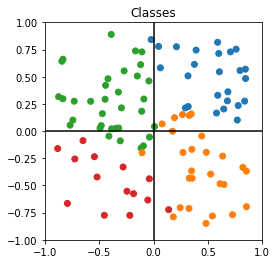

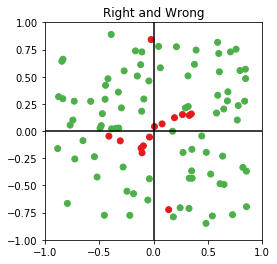

In [10]:
F_wtest = weighted_fidelity(F_test, opt_weights)
fig=draw_squares((X_test, F_wtest), title = 'Classes')

checks_wtest = (Y_test==F_wtest).astype(int)
fig=draw_squares((X_test, checks_wtest), check=True, title='Right and Wrong')

print('The classifier guesses the right label a {} % of times'.format(100* sum(checks_wtest) // len(checks_wtest)))

The last step is to test the classifier with an actual quantum computer or a noisy simulation. 

Checking with noise model
The classifier guesses the right label a 86 % of times


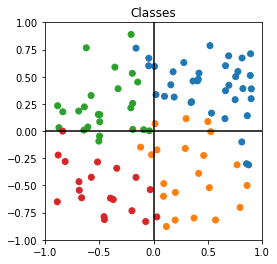

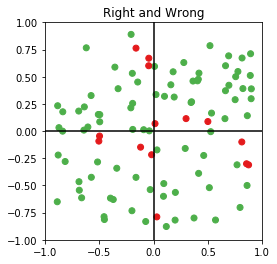

In [11]:
qtest=100
X_qtest = 1.8*np.random.rand(qtest, 2) - .9
Y_qtest = squares_labels(X_qtest)

F_qtest = check_squares_1q(X_qtest, optimal_parameters, simulator, err_like_dev=quantum_device)  # For a noisy simulation
#F_qtest = check_squares_1q(X_qtest, optimal_parameters, quantum_device) # For an actual quantum device

opt_weights = get_optimal_weights(Y_qtest, F_qtest)

F_wqtest = weighted_fidelity(F_qtest, opt_weights)
fig=draw_squares((X_qtest, F_wqtest), title = 'Classes')

checks_wqtest = (Y_qtest==F_wqtest).astype(int)
fig=draw_squares((X_qtest, checks_wqtest), check=True, title='Right and Wrong')

print('The classifier guesses the right label a {} % of times'.format(100* sum(checks_wqtest) // len(checks_wqtest)))

## Conclusions

We showed that it is possible to classify non-binary data using only one qubit. This extends the results obtained in the first part of this tutorial. The non-trivial step we took here is to notice that there is an infinite number of different states within the Bloch sphere. Thus, we can assign infinite label states for infinite labels. In principle, if we have no bounds on precision or shots on the execution of the quantum computations, we can use one qubit for classifying any kind of data. 

However, we can reach the quantum advantage regime only if we use more than one qubit and entanglement. This extension is about to be done, during the Vol. III of this tutorial.

#### References


[1] PÃ©rez-Salinas, A., Cervera-Lierta, A., Gil-Fuster, E., & Latorre, J. I. (2019). *Data re-uploading for a universal quantum classifier.* arXiv preprint [arXiv:1907.02085](https://arxiv.org/abs/1907.02085)<br>
<br>

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table